In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

plt.style.use('dark_background')

In [4]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [5]:
y

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
       ...  
437    178.0
438    104.0
439    132.0
440    220.0
441     57.0
Name: target, Length: 442, dtype: float64

### Gradient boosting machine (GBM)

#### 1 tree

In [6]:
# learning tree 1
tree1 = DecisionTreeRegressor(max_depth=3, random_state=2)
tree1.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=2)

In [7]:
# prediction 1
prediction1 = tree1.predict(X)
R2 = r2_score(y, prediction1)
R2

0.5006720154703376

In [8]:
# residual 1
residual1 = y - prediction1
y[2], prediction1[2], residual1[2]

(141.0, 208.57142857142858, -67.57142857142858)

#### 2 tree

In [9]:
# learning tree 2
tree2 = DecisionTreeRegressor(max_depth=3, random_state=2)
tree2.fit(X, residual1)

DecisionTreeRegressor(max_depth=3, random_state=2)

In [10]:
# prediction 2
prediction2 = tree1.predict(X) + tree2.predict(X)

# summing of trees predictions 1 & 2
R2 = r2_score(y, prediction2)
R2

0.5785866108916171

In [11]:
# residual 2
residual2 = y - prediction2
y[2], prediction2[2], residual2[2]

(141.0, 207.5052553799773, -66.50525537997731)

#### tree 3

In [12]:
# learning tree 3
tree3 = DecisionTreeRegressor(max_depth=3, random_state=2)
tree3.fit(X, residual2)

DecisionTreeRegressor(max_depth=3, random_state=2)

In [13]:
# prediction 3
prediction3 = tree1.predict(X) + tree2.predict(X) + tree3.predict(X)

R2 = r2_score(y, prediction3)
R2

0.6271203539706915

In [14]:
# residual 3
residual3 = y - prediction3
y[2], prediction3[2], residual3[2]

(141.0, 174.76070684814292, -33.76070684814292)

### Gradient boosting machine (GBR)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [18]:
def gb_predict(X, trees_list, eta):
    # Variant 1
    predictions = np.zeros(X.shape[0])  # [0, 0... x100]
    for i, x in enumerate(X):  # x -> 1 data-object with 10 features
        prediction = 0
        for alg in trees_list:  # alg -> 1 basic algorithm
            prediction += eta * alg.predict([x])[0]  # eta * b(x)

        predictions[i] = prediction

    # Variant 2
    # predictions = np.array(
    #     [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    # )

    return predictions

In [19]:
# error functionality
def mean_square_error(y, predicted):
    return np.mean((y - predicted)**2)

In [20]:
# L2' loss
def residual(y, z):
    return - (z - y)

In [21]:
# learning GBM
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):

    # future list of trees
    trees = []

    # future list of (train, test) errors
    train_errors = []
    test_errors = []
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        if len(trees) == 0:
            tree.fit(X_train, y_train)

            train_errors.append(mean_square_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_square_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # answers for current composition
            target = gb_predict(X_train, trees, eta)
            tree.fit(X_train, residual(y_train, target))

            train_errors.append(mean_square_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_square_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)

    return trees, train_errors, test_errors

In [22]:
# Examples
n_trees = 10
max_depth = 3
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [75]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Number of trees {n_trees}, max depth: {max_depth}, \
with step: {eta}, error in train: {mean_square_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Number of trees {n_trees}, max depth: {max_depth}, \
with step: {eta}, error in test: {mean_square_error(y_test, test_prediction)}')

In [ ]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

In [ ]:
# build graphs
def get_error_plot(n_trees, train_error, test_error):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_error, label='train error')
    plt.plot(list(range(n_trees)), test_error, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
get_error_plot(n_trees, train_errors, test_errors)

Number of trees 50, max depth: 5, with step: 0.1, error in train: 1.9479433089514488e-05
Number of trees 50, max depth: 5, with step: 0.1, error in test: 0.057447052675495845


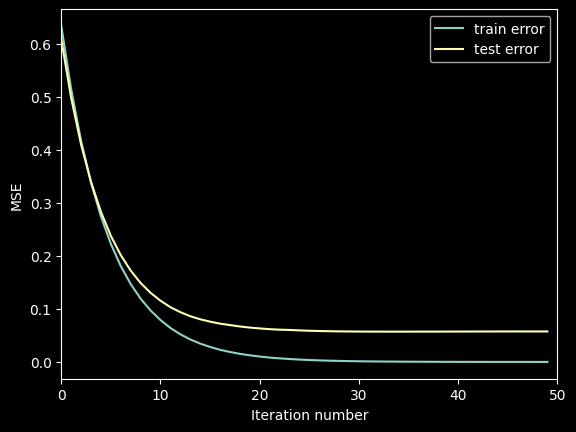

In [77]:
n_trees = 50
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
get_error_plot(n_trees, train_errors, test_errors)

Number of trees 50, max depth: 5, with step: 0.1, error in train: 1.9479433089514488e-05
Number of trees 50, max depth: 5, with step: 0.1, error in test: 0.057447052675495845


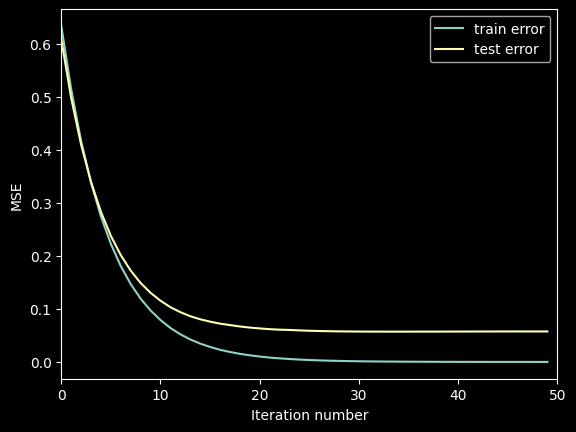

In [78]:
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
get_error_plot(n_trees, train_errors, test_errors)

Number of trees 50, max depth: 5, with step: 0.01, error in train: 0.23346301569387584
Number of trees 50, max depth: 5, with step: 0.01, error in test: 0.24835901536460675


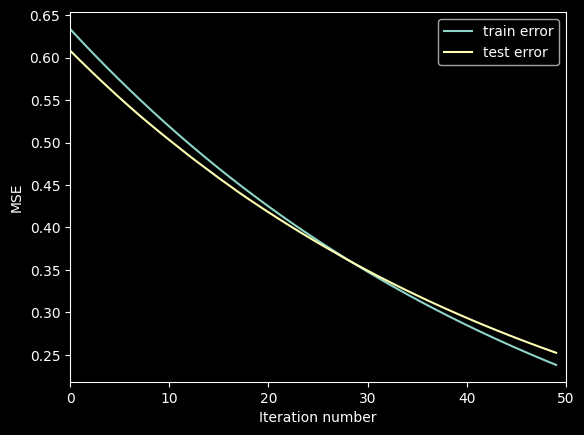

In [79]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
get_error_plot(n_trees, train_errors, test_errors)

In [ ]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
get_error_plot(n_trees, train_errors, test_errors)

#### Adaboost

In [ ]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [ ]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.shape, y.shape

In [ ]:
np.random.seed(6)

index = np.random.randint(0, X.shape[0], 1)
X_test = X.loc[index]
y_test = y.loc[index]
X.columns

In [ ]:
X = X.loc[[ 41,  44,  73,  81,  89,  91, 135, 146, 484, 491]]
y = y.loc[[ 41,  44,  73,  81,  89,  91, 135, 146, 484, 491]]
X

In [35]:
y

41     0
44     0
73     0
81     1
89     1
91     0
135    0
146    0
484    1
491    1
Name: target, dtype: int32

In [36]:
n_objects = X.shape[0]
w = np.ones(n_objects)
display(w)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

[Text(0.5, 0.75, 'mean texture <= 16.22\ngini = 0.48\nsamples = 10\nvalue = [6, 4]'),
 Text(0.25, 0.25, 'gini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]')]

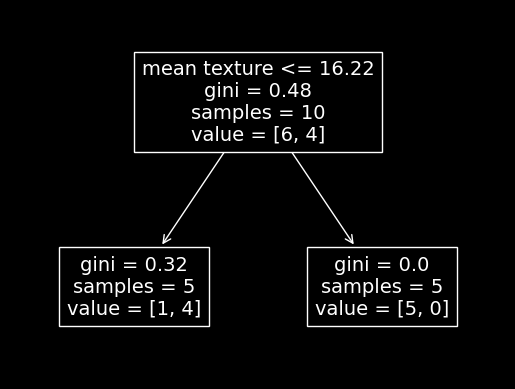

In [37]:
stump1 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump1.fit(X, y, sample_weight=w)

pred = stump1.predict(X)
plot_tree(stump1, feature_names=X.columns)

In [38]:
pred == y

41      True
44      True
73     False
81      True
89      True
91      True
135     True
146     True
484     True
491     True
Name: target, dtype: bool

In [39]:
error1 = sum(pred != y) / len(pred)
error1

0.1

In [40]:
def amount_of_say(x):
    return 1/2 * np.log((1-x) / x)

C:\Users\grayni\AppData\Local\Temp\ipykernel_16808\1977356716.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/2 * np.log((1-x) / x)
C:\Users\grayni\AppData\Local\Temp\ipykernel_16808\1977356716.py:2: RuntimeWarning: divide by zero encountered in log
  return 1/2 * np.log((1-x) / x)


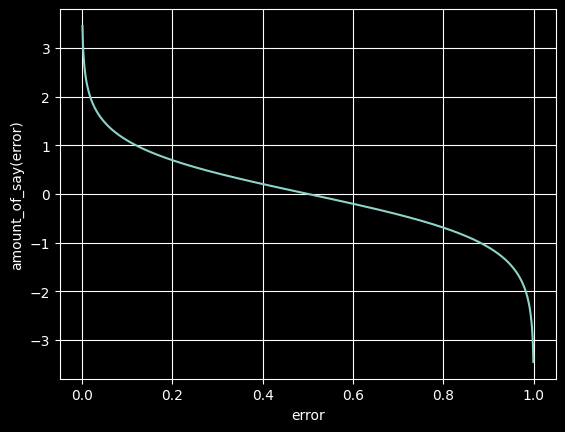

In [41]:
dots = np.linspace(0, 1, 1000)
amount_of_say_value = list(map(amount_of_say, dots))

plt.xlabel('error')
plt.ylabel('amount_of_say(error)')
plt.grid()
plt.plot(dots, amount_of_say_value)
plt.show()

In [42]:
alpha1 = 1/2 * np.log((1 - error1) / error1)
alpha1

1.0986122886681098

In [43]:
def new_sample_weight(x):
    return np.exp(x)

In [44]:
0.1 * np.exp(3.5)

3.3115451958692312

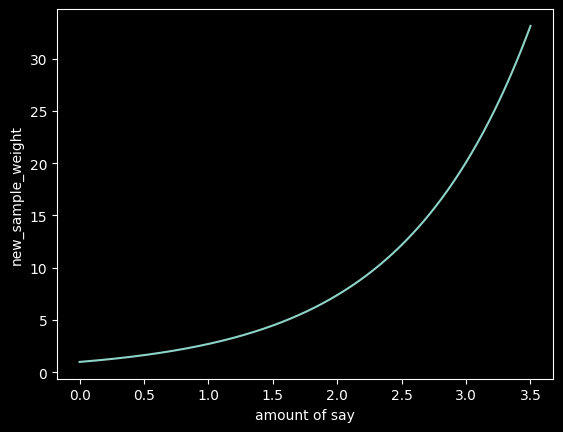

In [45]:
dots = np.linspace(0, 3.5, 1000)
new_sample_weight_value = list(map(new_sample_weight, dots))
plt.xlabel('amount of say')
plt.ylabel('new_sample_weight')
plt.plot(dots, new_sample_weight_value)
plt.show()

In [46]:
wrong_mask = pred != y
w[wrong_mask] *= np.exp(alpha1)
display(w)

array([1., 1., 3., 1., 1., 1., 1., 1., 1., 1.])

In [47]:
def new_sample_weight(x):
    return np.exp(-x)

In [48]:
0.1 * np.exp(-3.5)

0.00301973834223185

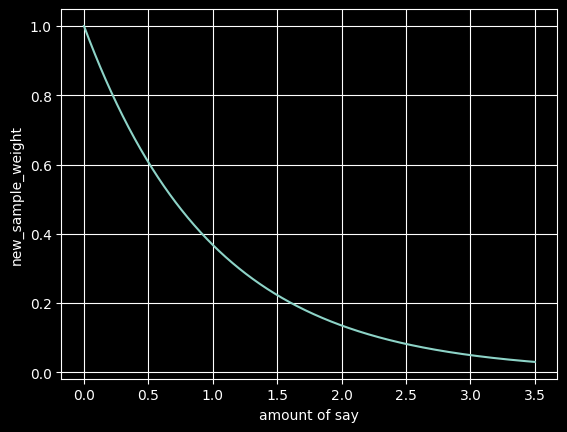

In [49]:
dots = np.linspace(0, 3.5, 1000)
new_sample_weight_value = list(map(new_sample_weight, dots))

plt.xlabel('amount of say')
plt.ylabel('new_sample_weight')
plt.grid()
plt.plot(dots, new_sample_weight_value)
plt.show()

In [50]:
w[~wrong_mask] *= np.exp(-alpha1)
display(w)

array([0.33333333, 0.33333333, 3.        , 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333])

In [51]:
sum(w)

5.999999999999998

In [52]:
w /= sum(w)
display(w)

array([0.05555556, 0.05555556, 0.5       , 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556])

In [53]:
sum(w)

1.0000000000000004

[Text(0.5, 0.75, 'mean texture <= 15.515\ngini = 0.346\nsamples = 10\nvalue = [0.778, 0.222]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0.0, 0.167]'),
 Text(0.75, 0.25, 'gini = 0.124\nsamples = 7\nvalue = [0.778, 0.056]')]

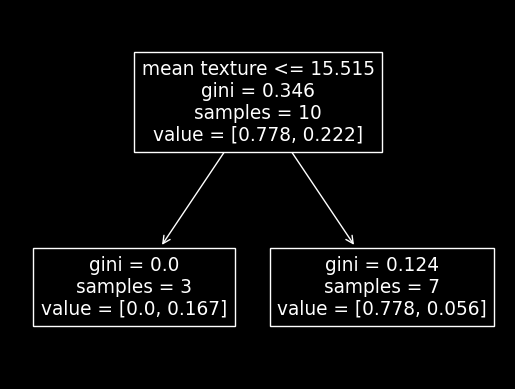

In [54]:
# stump2
stump2 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump2.fit(X, y, sample_weight=w)

pred = stump2.predict(X)
plot_tree(stump2, feature_names=X.columns)

In [55]:
display(pred != y)

41     False
44     False
73     False
81      True
89     False
91     False
135    False
146    False
484    False
491    False
Name: target, dtype: bool

In [56]:
error2 = sum(pred != y) / len(y)
alpha2 = 1/2 * np.log((1 - error2) / error2)

wrong_mask = pred != y
w[wrong_mask] *= np.exp(alpha2)

w[~wrong_mask] *= np.exp(-alpha2)

w /= sum(w)
display(w)

array([0.03846154, 0.03846154, 0.34615385, 0.34615385, 0.03846154,
       0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154])

In [57]:
stump3 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump3.fit(X, y, sample_weight=w)

pred = stump3.predict(X)
error3 = sum(pred != y) / len(y)
alpha3 = 1/2 * np.log((1 - error3) / error3)

wrong_mask = pred != y
w[wrong_mask] = w[wrong_mask] * np.exp(alpha3)

w[~wrong_mask] = w[~wrong_mask] * np.exp(-alpha3)
w /= sum(w)
display(w)

array([0.03125, 0.03125, 0.28125, 0.28125, 0.125  , 0.03125, 0.03125,
       0.03125, 0.03125, 0.125  ])

In [58]:
display(X_test, y_test)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
227,15.0,15.51,97.45,684.5,0.08371,0.1096,0.06505,0.0378,0.1881,0.05907,...,16.41,19.31,114.2,808.2,0.1136,0.3627,0.3402,0.1379,0.2954,0.08362


227    1
Name: target, dtype: int32

In [59]:
alpha1, alpha2, alpha3

(1.0986122886681098, 1.0986122886681098, 0.6931471805599453)

In [60]:
pred1 = stump1.predict(X_test)
pred2 = stump2.predict(X_test)
pred3 = stump3.predict(X_test)
pred1, pred2, pred3

(array([1]), array([1]), array([0]))

In [61]:
alpha1 + alpha2, alpha3

(2.1972245773362196, 0.6931471805599453)

In [62]:
pred = 1
y_test

227    1
Name: target, dtype: int32

### Realization AdaBoost

In [63]:
X, y = load_breast_cancer(return_X_y=True)
display(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

(569, 30)

(569,)

In [64]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

In [65]:
def adaboost(X, y, N):
    n_objects = len(X)
    n_classes = len(np.unique(y))
    w = np.ones(n_objects) / n_objects
    models = []

    for n in range(N):
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        error = get_error(predictions, y)

        if error >= 1 - 1 / n_classes:  # if error > 0.5
            continue

        if error == 0:
            error += 1e-10

        alpha = 0.5 * np.log((1 - error) / error)

        wrong_mask = predictions != y

        w[wrong_mask] *= np.exp(alpha)
        w[~wrong_mask] *= np.exp(-alpha)

        w /= w.sum()

        models.append((alpha, clf))

    return models

In [66]:
N = 50

models = adaboost(X_train, y_train, N)

In [67]:
np.zeros((10, 2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [68]:
def predict(X, models):
    n_classes = 2
    n_objects = len(X)

    y_pred = np.zeros((n_objects, n_classes))

    for alpha, clf in models:
        prediction = clf.predict(X)
        y_pred[range(n_objects), prediction] += alpha

    y_pred = np.argmax(y_pred, axis=1)

    return y_pred

In [69]:
print(f'{(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

96.948


In [70]:
print(f'{(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

94.406


In [71]:
train_errors = []
test_errors = []

for n in range(1, 31):
    models = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, models), y_train))
    test_errors.append(get_error(predict(X_test, models), y_test))

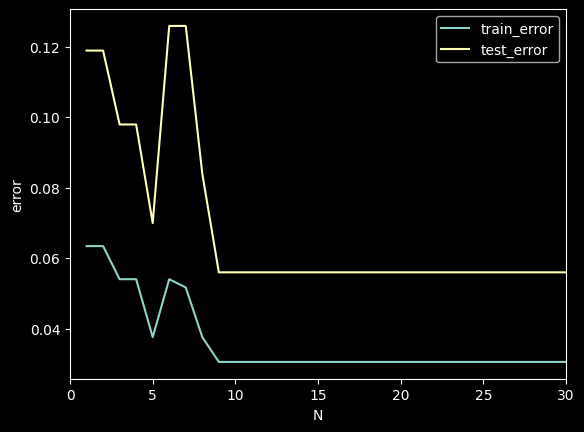

In [72]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train_error')
plt.plot(x, test_errors, label='test_error')
plt.xlabel('N')
plt.ylabel('error')
plt.legend(loc='upper right')
plt.show()